# Assignment 1

### Business Understanding

Introduction - The Iowa Liquor Sales dataset is an API from Google’s Bigquery which contains the spirits purchase detail of Iowa Class “E” liquor license holders by product, date of purchase, and location the item was purchased from. The timeframe of this data starts from January 1, 2012 through 2019. As part of the study commissioned by the Iowa Department of Commerce, all alcoholic sales within the state were logged into the Department system, and in turn, published as open data by the State of Iowa. The dataset contains detail on the name, product, quantity and location of the individual container or package sale. 

1. Set Objectives: We are a new and emerging Whisky brand who specializes in single-malt Rye, and we have targeted the state of Iowa for our next brand expansion. Before doing so, our goal will be to identify and predict which markets are more likely to sell greater volumes of whiskey, so that we can more efficiently spend our marketing dollars and inventory with little waste or buyback. Related questions also include, which brands are going to sell the most in each market, what parts of the year are going to have higher whiskey sales as opposed to lower whiskey sales to optimize advertising dollars, and what features of a town are defining characteristics of a large whiskey seller. 

2. Product Project Plan: To meet our goals, we will first use the Google Bigquery API to access the publicly available Iowa Liquor Sales data via python and Jupyter Notebook. Since the dataset is over 17 million lines of data, we will focus just on 2 months worth of data to do the cleaning. From here, we will define a subset to grant us 30,000 observations, address missing values and begin to build models that could help us answer questions based on markets likely to sell more whiskey. For our data on times of the year when we will sell more whiskey, we will need to create a subset of a full year’s data to build a time series model. For the town features, we will need to include additional information about the zip codes of iowa (such as population, income, ect) to get more demographic detail on each market to assist with a program for a clustering problem. For each of these problems, we will create a training and testing data set to help tune our predictions. 

3. Business Success Criteria - For our prediction models of market sales, we will be consider our model successful if we are able to classify our alochol type with a strong precision, recall and accuracy using a cross validation. Ideally, if we are dealing with 5 alcohol types, we will want to be able to predict whiskey accurately over 20% of the time. 

From the sale price prediction problem, we will run a linear regression technique against the remaining features. For this technique, we will use Root Mean Square Error to evaluate the effectiveness. A strong criteria for performance would be if we can get within $3 as an RMSE.

## Data Mining Type - Describe the meaning and type of data for each attribute in the data file

The data was collected via Google’s BigQuery tool in their Cloud Platform. The data was publicly available within the platform as an educational resource. The data is regularly updated through BigQuery, but .csv files can be found via sites like Kaggle.com. 

The description of all 24 fields of the data attributes can be found at https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy. We are working with the fields to start out with, to help begin the process of feature reduction and correlation analysis. Some of the data has no useful information for analysis, which we will likely be removing eventually. 

Below is a description of each feature available in the data set.

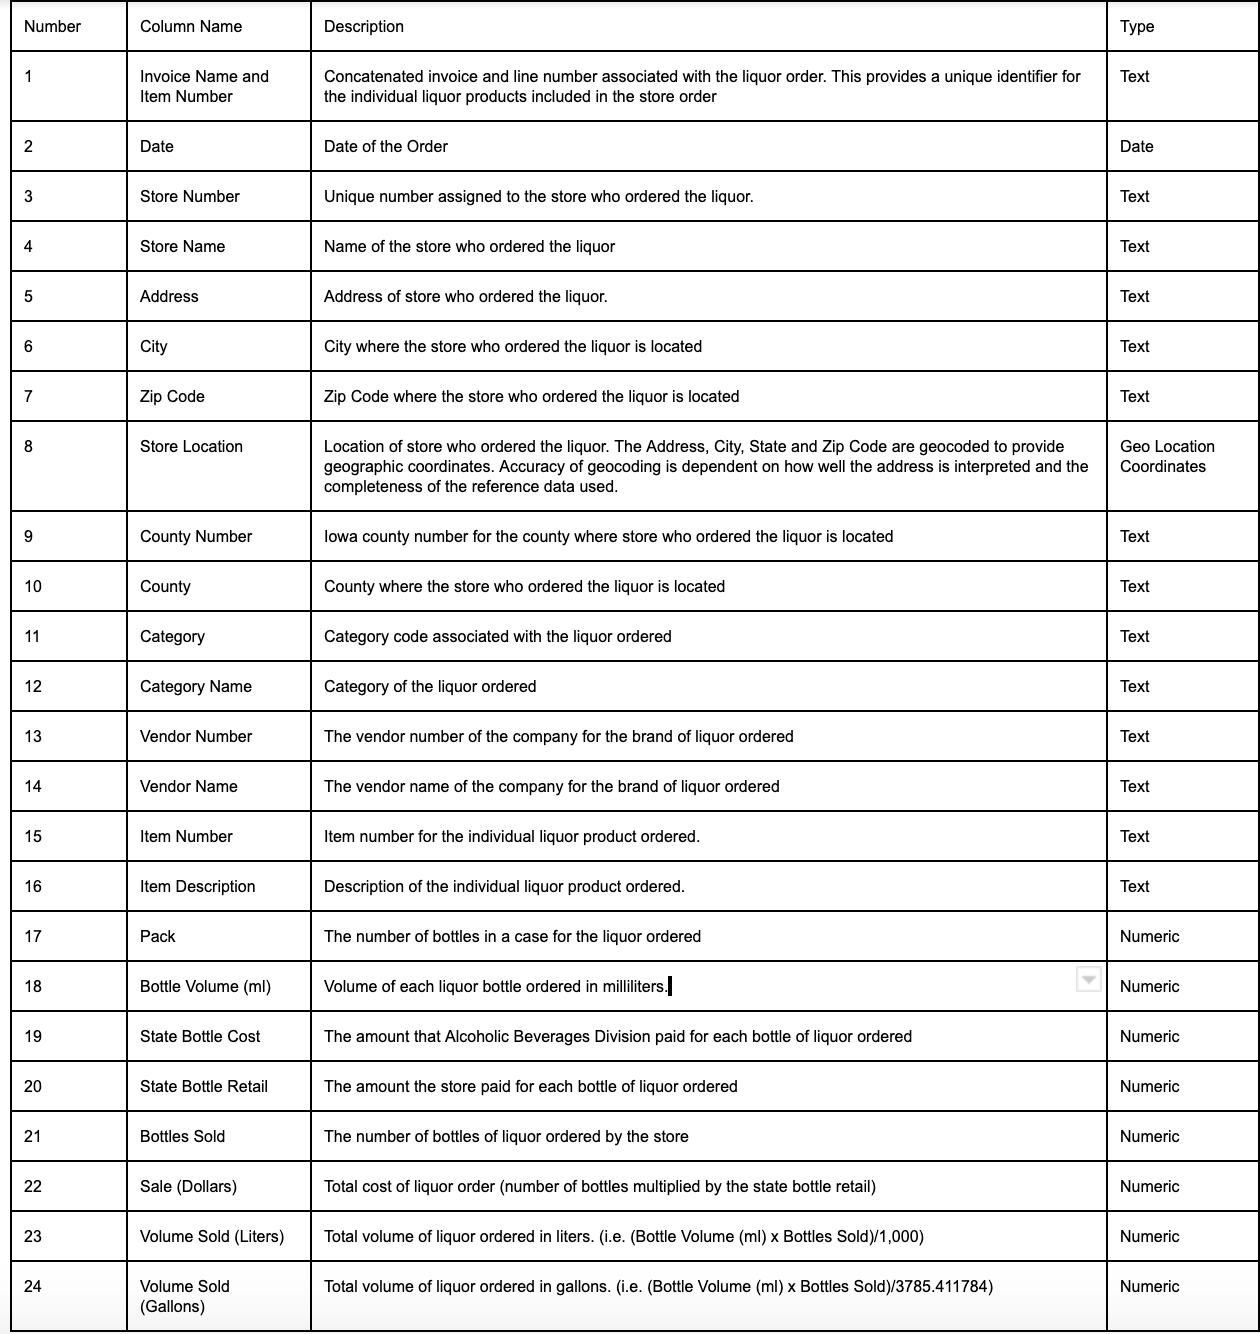

## Data Quality

In [2]:
# below is import of python packages.
try:
    from collections import abc as collections_abc
except ImportError:  # Python 2.7
    import collections as collections_abc

    import copy
import functools
import gzip
import io
import itertools
import json
import math
import os
import tempfile
import uuid
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import numpy as np
#import altair as alt
import matplotlib.pyplot as plt
import re

# Imports the Google Cloud client library
#from google.cloud import storage
from google.oauth2 import service_account
from google.cloud import bigquery

### Load in the Data

In order to load in our data, we will need to create a project id and save in our .json credentials from BigQuery onto our local machine. From there, we can set the client variable to map the credentials to our service account in our bigquery program. 

In [2]:
#project = 'macro-campaign-202100'
#credentials = service_account.Credentials.from_service_account_file(r'/Users/danielclark/Desktop/SMU/data_mining/My Project-71c2d48ddfb0.json')
#project = 'flash-ward-264717'
#credentials = service_account.Credentials.from_service_account_file(r'/Users/jjsch/Downloads/My Project 35341-372d7a58bfb3.json')
#C:\Users\jjsch\Downloads


#client = bigquery.Client(credentials=credentials, project=project)


In [3]:
#begindate = '2012-01-01'
#enddate = '2012-03-31'
  
#query = "select * FROM `bigquery-public-data.iowa_liquor_sales.sales` where date > '" +begindate + "' and date <= '" + enddate +"' --LIMIT " 
#df = client.query(query).to_dataframe()

df =  pd.read_csv(r'/Users/jjschued/Documents/Github/7331DataMiningNotebooks/lab1/iowa_subset_2019_400k_random_rows.csv', nrows = 50000)

For our measurement, we will be querying the first two months of data in 2012 (from Jan 01 through March 01, 2012) using our SQL command limiting our data to the first 30,000 rows. 

In [4]:
df.info

<bound method DataFrame.info of       invoice_and_item_number        date  store_number  \
0             INV-23084400002  2019-11-07          3869   
1             INV-23282200001  2019-11-18          4617   
2             INV-19435800130  2019-05-17          2560   
3             INV-23454200002  2019-11-25          2614   
4             INV-23541200001  2019-11-27          2629   
5             INV-23540300028  2019-11-27          4312   
6             INV-19655400089  2019-05-29          2517   
7             INV-23687700099  2019-12-05          2545   
8             INV-17141800065  2019-01-25          5210   
9             INV-23109300014  2019-11-08          5411   
10            INV-23072700074  2019-11-06          2642   
11            INV-19202100034  2019-05-07          5173   
12            INV-23553600002  2019-11-29          2190   
13            INV-23551100140  2019-11-27          2565   
14            INV-23566000005  2019-11-29          4192   
15            INV-199703

In [26]:
df.to_csv(index=False)

'f0_\n2380345\n'

In [5]:
df.columns.values

array(['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number',
       'vendor_name', 'item_number', 'item_description', 'pack',
       'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail',
       'bottles_sold', 'sale_dollars', 'volume_sold_liters',
       'volume_sold_gallons'], dtype=object)

Running a df.columns.values function, confirms the 24 features that we referenced in our Data understanding phase. This now allows us to move forward with our data cleaning. 

### Data Cleaning

In our data cleaning step, we need to perform two specific data cleaning operations. 1.) We will need to convert our features to the correct continuous, ordinal and categorical features, and 2.) we will need to address the missing values. 

To begin the process of addressing missing values so that we can convert our data types, we will replace all "?", which our dataset denotes as null, into "-1" values (not strings). From here, we will convert state_bottle_cost, state_bottle_retail, sale_dollars, volume_sold_liters, and volume_sold_gallons into continuous variables so they register as floats. 


In addition, we will need to convert the varaible "bottles_sold" into ordinal features so they register as an integer value in our models. 

Thirdly, we will want to replace the values for pack, bottle_volume_ml, store_number, store_name, address, city, zip_code, county_number, county, category, category_name, vendor_number, vendor_name, item_number and item_description into categorical variables so they register as a non-null object in our model.

Using a df.info function helps to verify this. 

The following will do some cleanup on values and categorize store, category, and dates into more summarized values

In [6]:
df.dtypes

invoice_and_item_number     object
date                        object
store_number                 int64
store_name                  object
address                     object
city                        object
zip_code                   float64
store_location              object
county_number              float64
county                      object
category                   float64
category_name               object
vendor_number                int64
vendor_name                 object
item_number                  int64
item_description            object
pack                         int64
bottle_volume_ml             int64
state_bottle_cost          float64
state_bottle_retail        float64
bottles_sold                 int64
sale_dollars               float64
volume_sold_liters         float64
volume_sold_gallons        float64
dtype: object

In [7]:
df['category_name'] = df['category_name'].str.upper()

In [8]:
df['category_name'][40:200]

40          TEMPORARY & SPECIALTY PACKAGES
41          TEMPORARY & SPECIALTY PACKAGES
42                              TRIPLE SEC
43                       IMPORTED DRY GINS
44                       IMPORTED DRY GINS
45                       IMPORTED DRY GINS
46                           AGED DARK RUM
47                              TRIPLE SEC
48                              TRIPLE SEC
49                       IMPORTED DRY GINS
50     AMERICAN DISTILLED SPIRIT SPECIALTY
51                       IMPORTED DRY GINS
52          TEMPORARY & SPECIALTY PACKAGES
53                       IMPORTED DRY GINS
54                       IMPORTED DRY GINS
55                       IMPORTED DRY GINS
56                         COFFEE LIQUEURS
57          TEMPORARY & SPECIALTY PACKAGES
58                       IMPORTED DRY GINS
59          TEMPORARY & SPECIALTY PACKAGES
60                                GOLD RUM
61          NEUTRAL GRAIN SPIRITS FLAVORED
62                         COFFEE LIQUEURS
63         

In [9]:
df = (df.replace(r'^\s*$', np.nan, regex=True))

In [10]:
df = (df.replace(np.nan, 'blank', regex=True))

In [11]:
#download to categorize in more summarized manner
#liquortcatlistdf.to_csv("C:\\Users\\jjsch\\downloads\\liquorcats.csv")    
#import the file
#liquortcatlistdf = pd.read_csv("C:\\Users\\jjsch\\downloads\\liquorcats.csv")
#liquortcatlistdf = pd.read_csv("C:\\Users\\jjschued\\Documents\\SMU\\7331 Machine Learning\\Github\\7331DataMiningNotebooks\\liquorcats.csv")
#liquortcatlistdf.dtypes

#grouping all the store locations into parent stores
df['Category'] = 'Other'
df.loc[df['category_name'].str.contains('GINS'), 'Category'] = 'GIN'
df.loc[df['category_name'].str.contains('GINS'), 'Category'] = 'GIN'
df.loc[df['category_name'].str.contains('GIN'), 'Category'] = 'GIN'
df.loc[df['category_name'].str.contains('RUMS'), 'Category'] = 'RUM'
df.loc[df['category_name'].str.contains('RUM'), 'Category'] = 'RUM'
df.loc[df['category_name'].str.contains('SCOTCH'), 'Category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('WHISKIES'), 'Category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('WHISKY'), 'Category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('WHISKEY'), 'Category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('RYE'), 'Category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('AMARETTO'), 'Category'] = 'AMARETTO'
df.loc[df['category_name'].str.contains('BOURBON'), 'Category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('LIQUEURS'), 'Category'] = 'LIQUEUR'
df.loc[df['category_name'].str.contains('LIQUEUR'), 'Category'] = 'LIQUEUR'
df.loc[df['category_name'].str.contains('VODKAS'), 'Category'] = 'VODKA'
df.loc[df['category_name'].str.contains('VODKA'), 'Category'] = 'VODKA'
df.loc[df['category_name'].str.contains('BRANDY'), 'Category'] = 'BRANDY'
df.loc[df['category_name'].str.contains('BRANDIES'), 'Category'] = 'GIN'
df.loc[df['category_name'].str.contains('CREME'), 'Category'] = 'SCHNAPPS'
df.loc[df['category_name'].str.contains('SCHNAPPS'), 'Category'] = 'SCHNAPPS'
df.loc[df['category_name'].str.contains('TEQUILA'), 'Category'] = 'TEQUILA'
df.loc[df['category_name'].str.contains('TEQUILAS'), 'Category'] = 'TEQUILA'




In [13]:
#get a few stray not available categories per internet this is tequila
df.loc[df['item_description'] == 'Herradura Gold Reposado 6pak', 'Category'] = "Tequila"
df.loc[df['item_description'] == 'Chambord Liqueur w/2 Glasses', 'Category'] = "Liquers"

#grouping all the store locations into parent stores
df['store_parent'] = 'Other'
df.loc[df['store_name'].str.contains('Hy-Vee'), 'store_parent'] = 'Hy-Vee'
df.loc[df['store_name'].str.contains('Wal-Mart'), 'store_parent'] = 'Wal-Mart'
df.loc[df['store_name'].str.contains('SamsClub'), 'store_parent'] = 'SamsClub'
df.loc[df['store_name'].str.contains('Fareway'), 'store_parent'] = 'Fareway'
df.loc[df['store_name'].str.contains('Kum&Go'), 'store_parent'] = 'Kum&Go'
df.loc[df['store_name'].str.contains('CVS'), 'store_parent'] = 'CVS'
df.loc[df['store_name'].str.contains('Target'), 'store_parent'] = 'Target'
df.loc[df['store_name'].str.contains('Caseys'), 'store_parent'] = 'Caseys'
df.loc[df['store_name'].str.contains('Dahls'), 'store_parent'] = 'Dahls'
df.loc[df['store_name'].str.contains('WAL-MART'), 'store_parent'] = 'Wal-Mart'
df.loc[df['store_name'].str.contains('HY-VEE'), 'store_parent'] = 'Hy-Vee'
df.loc[df['store_name'].str.contains('KUM&GO'), 'store_parent'] = 'Kum&Go'
df.loc[df['store_name'].str.contains('QuikTrip'), 'store_parent'] = 'QuikTrip'


#labored conversion of dates to month year and month year by converting to strings
df['month'] = pd.DatetimeIndex(df['date']).month
df['year'] = pd.DatetimeIndex(df['date']).year

df.loc[df['month'] ==1 , 'month'] = 'Jan'
df.loc[df['month'] ==2 , 'month'] = 'Feb'
df.loc[df['month'] ==3 , 'month'] = 'Mar'
df.loc[df['month'] ==4 , 'month'] = 'Apr'
df.loc[df['month'] ==5 , 'month'] = 'May'
df.loc[df['month'] ==6 , 'month'] = 'Jun'
df.loc[df['month'] ==7 , 'month'] = 'Jul'
df.loc[df['month'] ==8 , 'month'] = 'Aug'
df.loc[df['month'] ==9 , 'month'] = 'Sep'
df.loc[df['month'] ==10 , 'month'] = 'Oct'
df.loc[df['month'] ==11 , 'month'] = 'Nov'
df.loc[df['month'] ==12 , 'month'] = 'Dec'


df.loc[df['year'] ==2012 , 'year'] = '2012'
df.loc[df['year'] ==2013 , 'year'] = '2013'
df.loc[df['year'] ==2014 , 'year'] = '2014'
df.loc[df['year'] ==2015 , 'year'] = '2015'
df.loc[df['year'] ==2016 , 'year'] = '2016'
df.loc[df['year'] ==2017 , 'year'] = '2017'
df.loc[df['year'] ==2018 , 'year'] = '2018'
df.loc[df['year'] ==2019 , 'year'] = '2019'

#merge year and month together
df['monthyear'] = df['month'] + "-" + df['year']

In [14]:
df.head(200)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Category,store_parent,month,year,monthyear
0,INV-23084400002,2019-11-07,3869,Bootleggin' Barzini's Fin,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,...,5.78,20,115.60,7.50,1.98,Other,Other,Nov,2019,Nov-2019
1,INV-23282200001,2019-11-18,4617,Lickety Liquor,2501 HUBBELL AVE,Des Moines,50317,POINT (-93.570489 41.607817),77,POLK,...,13.13,1,13.13,0.05,0.01,Other,Other,Nov,2019,Nov-2019
2,INV-19435800130,2019-05-17,2560,Hy-Vee Food Store / Marion,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,...,24.75,6,148.50,6.00,1.58,GIN,Hy-Vee,May,2019,May-2019
3,INV-23454200002,2019-11-25,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,...,31.76,24,762.24,18.00,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019
4,INV-23541200001,2019-11-27,2629,Hy-Vee Food Store #2 / Council Bluffs,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,...,13.97,12,167.64,21.00,5.54,Other,Hy-Vee,Nov,2019,Nov-2019
5,INV-23540300028,2019-11-27,4312,I-80 Liquor / Council Bluffs,2411 S 24TH ST #1,Council Bluffs,51501,POINT (-95.8792 41.238092),78,POTTAWATTA,...,43.47,6,260.82,6.00,1.58,WHISKY,Other,Nov,2019,Nov-2019
6,INV-19655400089,2019-05-29,2517,Hy-Vee Food Store #1 / Newton,1501 First Avenue East,Newton,50208,POINT (-93.034296 41.69916),50,JASPER,...,7.35,12,88.20,6.00,1.58,Other,Hy-Vee,May,2019,May-2019
7,INV-23687700099,2019-12-05,2545,Hy-Vee Drugstore / Iowa City,310 N 1st St,Iowa City,52245,POINT (-91.528105 42.207428),52,JOHNSON,...,12.75,30,382.50,22.50,5.94,Other,Hy-Vee,Dec,2019,Dec-2019
8,INV-17141800065,2019-01-25,5210,Ding's Honk'n Holler,"900, E Washington St",Clarinda,51632,POINT (-95.027238 40.739231),73,PAGE,...,13.13,2,26.26,0.60,0.15,Other,Other,Jan,2019,Jan-2019
9,INV-23109300014,2019-11-08,5411,Bluejay Market,2810 Wills Ave,Perry,50220,POINT (-94.081127 41.838488),25,DALLAS,...,50.01,6,300.06,6.00,1.58,Other,Other,Nov,2019,Nov-2019


In [40]:
import numpy as np
# replace '?' with -1, we will deal with missing values later
df = df.replace(to_replace='?',value=-1) 

categorical_features = ['city', 'county',  'category_name','vendor_name', 'store_number', 'item_description','store_parent', 
                        'monthyear', 'Category', 'county_number', 'vendor_number', 'item_number']

# let's start by first changing the numeric values to be floats
continuous_features = ['state_bottle_cost', 'state_bottle_retail', 'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons', 'bottles_sold']

# and the oridnal values to be integers
ordinal_features = ['pack', 'bottle_volume_ml']

# use the "astype" function to change the variable type
df[continuous_features] = df[continuous_features].astype(np.float64)
df[ordinal_features] = df[ordinal_features].astype(np.int64)

df.info() # now our data looks better!!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
store_number           50000 non-null int64
vendor_number          50000 non-null int64
item_number            50000 non-null int64
pack                   50000 non-null int64
bottle_volume_ml       50000 non-null int64
state_bottle_cost      50000 non-null float64
state_bottle_retail    50000 non-null float64
bottles_sold           50000 non-null float64
sale_dollars           50000 non-null float64
volume_sold_liters     50000 non-null float64
volume_sold_gallons    50000 non-null float64
Category               50000 non-null object
store_parent           50000 non-null object
monthyear              50000 non-null object
cost_per_liter         50000 non-null float64
dtypes: float64(7), int64(5), object(3)
memory usage: 5.7+ MB


In [16]:
dfstats = df.describe() # will get summary of continuous or the nominals

# let's set those values to NaN, so that Pandas understand they are missing
df = df.replace(to_replace=-1,value=np.nan) # replace -1 with NaN (not a number)
print (df.info())
dfstats2 = df.describe() # scroll over to see the values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 29 columns):
invoice_and_item_number    50000 non-null object
date                       50000 non-null object
store_number               50000 non-null int64
store_name                 50000 non-null object
address                    50000 non-null object
city                       50000 non-null object
zip_code                   50000 non-null object
store_location             50000 non-null object
county_number              50000 non-null object
county                     50000 non-null object
category                   50000 non-null object
category_name              50000 non-null object
vendor_number              50000 non-null int64
vendor_name                50000 non-null object
item_number                50000 non-null int64
item_description           50000 non-null object
pack                       50000 non-null int64
bottle_volume_ml           50000 non-null int64
state_bottle_c

From here, we are going to drop the following variables due to the fact that they will not play a factor in our prediction dataset. Rationale is below:

- store_name : removing due to avail of store_number variable, which will identify the specific store more succinctly
- store location: as we will be able to locate stores on zip code, city and county number, and there appears to be a bunch of nulls anyway.

In [17]:
dfna = df[df.isna().any(axis=1)]
dfna.isna().sum()

invoice_and_item_number    0
date                       0
store_number               0
store_name                 0
address                    0
city                       0
zip_code                   0
store_location             0
county_number              0
county                     0
category                   0
category_name              0
vendor_number              0
vendor_name                0
item_number                0
item_description           0
pack                       0
bottle_volume_ml           0
state_bottle_cost          0
state_bottle_retail        0
bottles_sold               0
sale_dollars               0
volume_sold_liters         0
volume_sold_gallons        0
Category                   0
store_parent               0
month                      0
year                       0
monthyear                  0
dtype: int64

Once we drop our store name, address, and store location variables, we can also look to address the county number nulls as well. Since 112 values is somewhat significant on a 30,000 value dataset, we can look to do some inputation with the other data. 

Since we can use city and zip code as a guide, let's take the values that appear in the respective city and zip code on other values, and replace it with the missing value. 

In [18]:
#Unique Value Threshold (Per Column)
#Delete Columns >  uniqueThreshold unique values prior to one-hot encoding. 
#(each unique value becomes a new column during one-hot encoding)
uniqueThreshold = 30
# in each column of dataframe
uniqueValues = df.nunique()
#Isolate continuous and categorical data types
#These are indexers into the schoolData dataframe and may be used similar to the schoolData dataframe 
D_boolean = df.loc[:, (df.dtypes == bool) ]
D_nominal = df.loc[:, (df.dtypes == object)]
D_continuous = df.loc[:, (df.dtypes != bool) & (df.dtypes != object)]
print ("Boolean Columns: ", D_boolean.shape[1])
print ("Nominal Columns: ", D_nominal.shape[1])
print ("Continuous Columns: ", D_continuous.shape[1])
print ("Columns Accounted for: ", D_nominal.shape[1] + D_continuous.shape[1] + D_boolean.shape[1])

#Delete categorical columns with > 30 unique values (Each unique value becomes a column during one-hot encoding)
oneHotUniqueValueCounts = df[D_nominal.columns].apply(lambda x: x.nunique())
oneHotUniqueValueCols = oneHotUniqueValueCounts[oneHotUniqueValueCounts >= uniqueThreshold].index
df.drop(oneHotUniqueValueCols, axis=1, inplace=True) 

Boolean Columns:  0
Nominal Columns:  18
Continuous Columns:  11
Columns Accounted for:  29


In [44]:
df.head()

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Category,store_parent,monthyear,cost_per_liter
0,20,375,3.85,5.78,20.0,115.60,7.50,1.98,Other,Other,Nov-2019,15.413333
1,8,50,8.75,13.13,1.0,13.13,0.05,0.01,Other,Other,Nov-2019,262.600000
2,12,1000,16.50,24.75,6.0,148.50,6.00,1.58,GIN,Hy-Vee,May-2019,24.750000
3,6,750,21.17,31.76,24.0,762.24,18.00,4.75,WHISKY,Hy-Vee,Nov-2019,42.346667
4,6,1750,9.31,13.97,12.0,167.64,21.00,5.54,Other,Hy-Vee,Nov-2019,7.982857


In [20]:
df[df.isnull().any(axis=1)][df.columns[df.isnull().any()]]

""


In [42]:
#one hot encoding

df = df.drop(columns=['vendor_number', 'item_number', 'store_number'])
#'month', 'year', 'county_number',
#Isolate continuous and categorical data types
#These are indexers into the schoolData dataframe and may be used similar to the schoolData dataframe 
D_boolean = df.loc[:, (df.dtypes == bool) ]
D_nominal = df.loc[:, (df.dtypes == object)]
D_continuous = df.loc[:, (df.dtypes != bool) & (df.dtypes != object)]
print ("Boolean Columns: ", D_boolean.shape[1])
print ("Nominal Columns: ", D_nominal.shape[1])
print ("Continuous Columns: ", D_continuous.shape[1])
print ("Columns Accounted for: ", D_nominal.shape[1] + D_continuous.shape[1] + D_boolean.shape[1])

one_hot_df = pd.concat([pd.get_dummies(df[col],prefix=col) for col in D_nominal.columns], axis=1)
one_hot_df.head()

Boolean Columns:  0
Nominal Columns:  3
Continuous Columns:  9
Columns Accounted for:  12


,Category_GIN,Category_LIQUEUR,Category_Other,Category_RUM,Category_TEQUILA,Category_VODKA,Category_WHISKY,store_parent_CVS,store_parent_Fareway,store_parent_Hy-Vee,...,monthyear_Dec-2019,monthyear_Feb-2019,monthyear_Jan-2019,monthyear_Jul-2019,monthyear_Jun-2019,monthyear_Mar-2019,monthyear_May-2019,monthyear_Nov-2019,monthyear_Oct-2019,monthyear_Sep-2019
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [43]:
dfstats2

,store_number,vendor_number,item_number,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,3685.072080,289.595480,63733.903480,11.772740,871.934060,13.394573,20.094518,11.510400,169.250258,10.519123,2.773666
std,1145.870369,129.287495,135796.349481,8.244936,455.928174,11.745491,17.618159,42.463618,585.357263,55.927518,14.774748
min,2106.000000,35.000000,159.000000,1.000000,50.000000,0.890000,1.340000,1.000000,2.570000,0.050000,0.010000
25%,2602.000000,255.000000,28233.000000,6.000000,750.000000,5.380000,8.070000,2.000000,36.000000,1.500000,0.390000
50%,3663.000000,300.000000,37418.000000,12.000000,750.000000,11.040000,16.560000,6.000000,76.800000,4.500000,1.180000
75%,4721.000000,395.000000,65307.000000,12.000000,1000.000000,18.090000,27.140000,12.000000,169.560000,10.500000,2.770000
max,9042.000000,978.000000,997095.000000,48.000000,6000.000000,262.460000,393.690000,2700.000000,37514.880000,4725.000000,1248.210000


In [23]:
df.head()

,store_number,vendor_number,item_number,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Category,store_parent,monthyear
0,3869,293,989215,20,375,3.85,5.78,20.0,115.60,7.50,1.98,Other,Other,Nov-2019
1,4617,346,86739,8,50,8.75,13.13,1.0,13.13,0.05,0.01,Other,Other,Nov-2019
2,2560,35,28233,12,1000,16.50,24.75,6.0,148.50,6.00,1.58,GIN,Hy-Vee,May-2019
3,2614,184,18350,6,750,21.17,31.76,24.0,762.24,18.00,4.75,WHISKY,Hy-Vee,Nov-2019
4,2629,285,902291,6,1750,9.31,13.97,12.0,167.64,21.00,5.54,Other,Hy-Vee,Nov-2019


### Outliers

In [45]:
# this python magics will allow plot to be embedded into the notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

In [25]:
df['Category'].value_counts()

VODKA      13027
WHISKY     10556
Other       9155
LIQUEUR     7007
RUM         5608
GIN         3101
TEQUILA     1546
Name: Category, dtype: int64

Looking at a quick boxplot of our 66 categories, along with the sale price, we can see there are a handfull of liquor sales that went north of $5,000, with two who have exceeded $25,000.

In [46]:
# selecting rows based on condition
exp_df = df[df['sale_dollars'] > 5000]

exp_df['cost_per_liter'] = exp_df['sale_dollars']/exp_df['volume_sold_liters']

print(exp_df[['sale_dollars', 'volume_sold_liters', 'cost_per_liter', 'Category']])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


       sale_dollars  volume_sold_liters  cost_per_liter Category
89         13791.60             1890.00        7.297143    Other
168         5591.04              768.00        7.280000    Other
230        13791.60             1890.00        7.297143    Other
276        13791.60             1890.00        7.297143    Other
296         5591.04              768.00        7.280000    Other
324        11182.08             1536.00        7.280000    Other
446         6003.00              130.50       46.000000   WHISKY
459         6895.80              945.00        7.297143    Other
621        10575.00              211.50       50.000000   WHISKY
649        13791.60             1890.00        7.297143    Other
664         5196.51               74.25       69.986667   WHISKY
720         5591.04              768.00        7.280000    Other
793         5591.04              768.00        7.280000    Other
815         9563.40              315.00       30.360000    Other
1011       12504.96      

## Simple Statistics

The df.describe funciton below provides some simple statistcs for the numeric values in the table. 

We can see that the average pack size is just over 12, with a median of exactly 12, so this would suggest our normality curve is very narrow (verified with the SD of 7.3 bottles and slightly right-skewed towards higher pack sizes. 

The average sale in our data set is $116.42 with a standard deviation of $415.62, which suggests there's a very wide variance of case prices in our data set. The median was $65.96 which suggests there are a few outliers in our data set for sales. Per our describe functions, the max sale was $27,183

All of our data has at least a count of 29,999 out of 30,000, with state_bottle_cost, state_bottle_retail, and sale_dollars.

In [47]:
df.describe()

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,cost_per_liter
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.772740,871.934060,13.394573,20.094518,11.510400,169.250258,10.519123,2.773666,33.018093
std,8.244936,455.928174,11.745491,17.618159,42.463618,585.357263,55.927518,14.774748,55.160884
min,1.000000,50.000000,0.890000,1.340000,1.000000,2.570000,0.050000,0.010000,3.200000
25%,6.000000,750.000000,5.380000,8.070000,2.000000,36.000000,1.500000,0.390000,10.960000
50%,12.000000,750.000000,11.040000,16.560000,6.000000,76.800000,4.500000,1.180000,21.333333
75%,12.000000,1000.000000,18.090000,27.140000,12.000000,169.560000,10.500000,2.770000,34.130000
max,48.000000,6000.000000,262.460000,393.690000,2700.000000,37514.880000,4725.000000,1248.210000,1800.000000


## Visualize Attributes
Visualize the most interesting attributes (at least 5 attributes, your opinion on what is interesting). Important: Interpret the implications for each visualization. Explain for each attribute why the chosen visualization is appropriate.



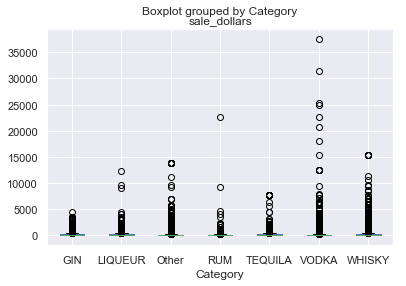

In [48]:
# pandas has some really powerful extensions to matplotlib for scientific computing 
ax = df.boxplot(column = 'sale_dollars', by = 'Category')
ax



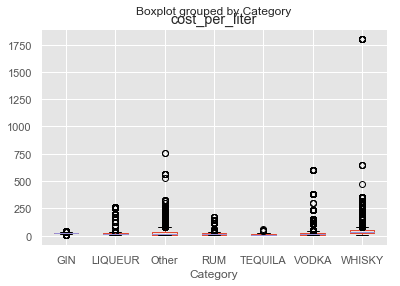

In [34]:
df['cost_per_liter'] = df['sale_dollars']/df['volume_sold_liters']


bx = df.boxplot(column = 'cost_per_liter', by = 'Category')
bx

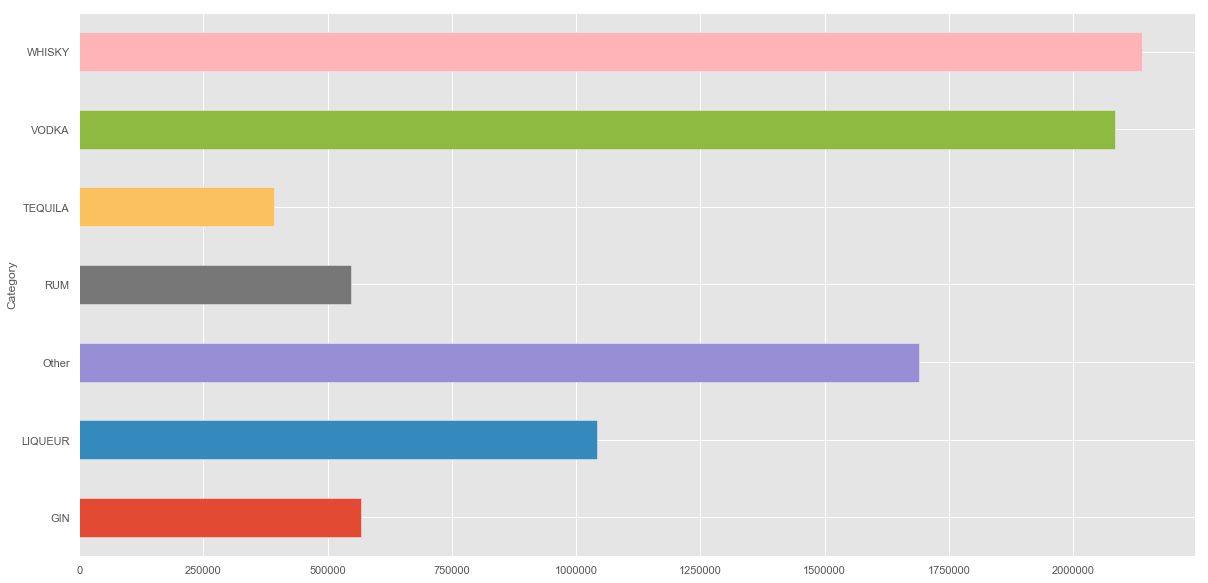

In [32]:
# Start by just plotting what we previsously grouped!
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
df_grouped = df.groupby(by=['Category'])
sales_rate = df_grouped.sale_dollars.sum()
ax = sales_rate.plot(kind='barh')

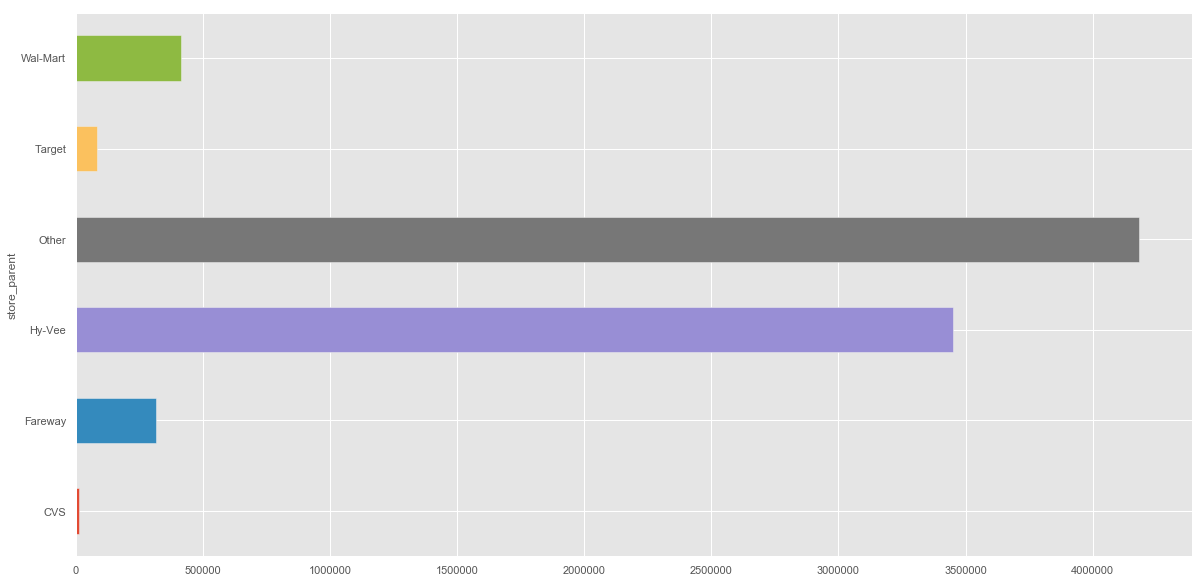

In [37]:
# Start by just plotting what we previsously grouped!
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
df_grouped = df.groupby(by=['store_parent'])
sales_rate = df_grouped.sale_dollars.sum()
ax = sales_rate.plot(kind='barh')

## Explore Joint Attributes
Visualize relationships between attributes: Look at the attributes via scatter plots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. Explain any interesting relationships.



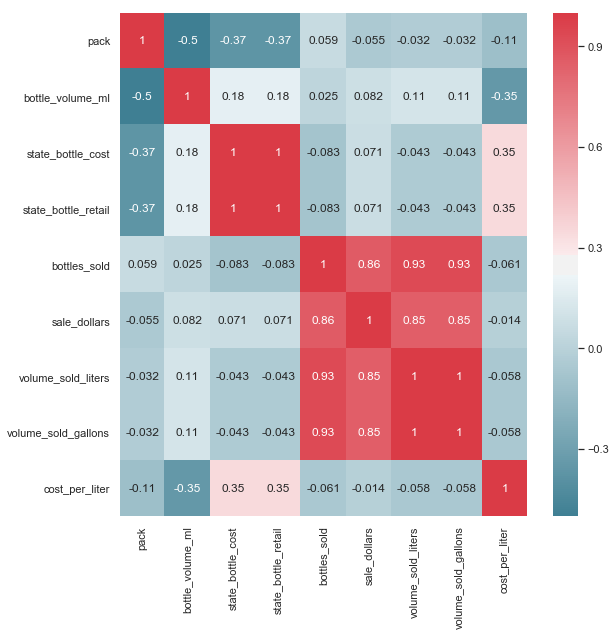

In [49]:
# plot the correlation matrix using seaborn
sns.set(style="darkgrid") # one of the many styles to plot using
f, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(df.corr(), cmap=cmap, annot=True)
f.tight_layout()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


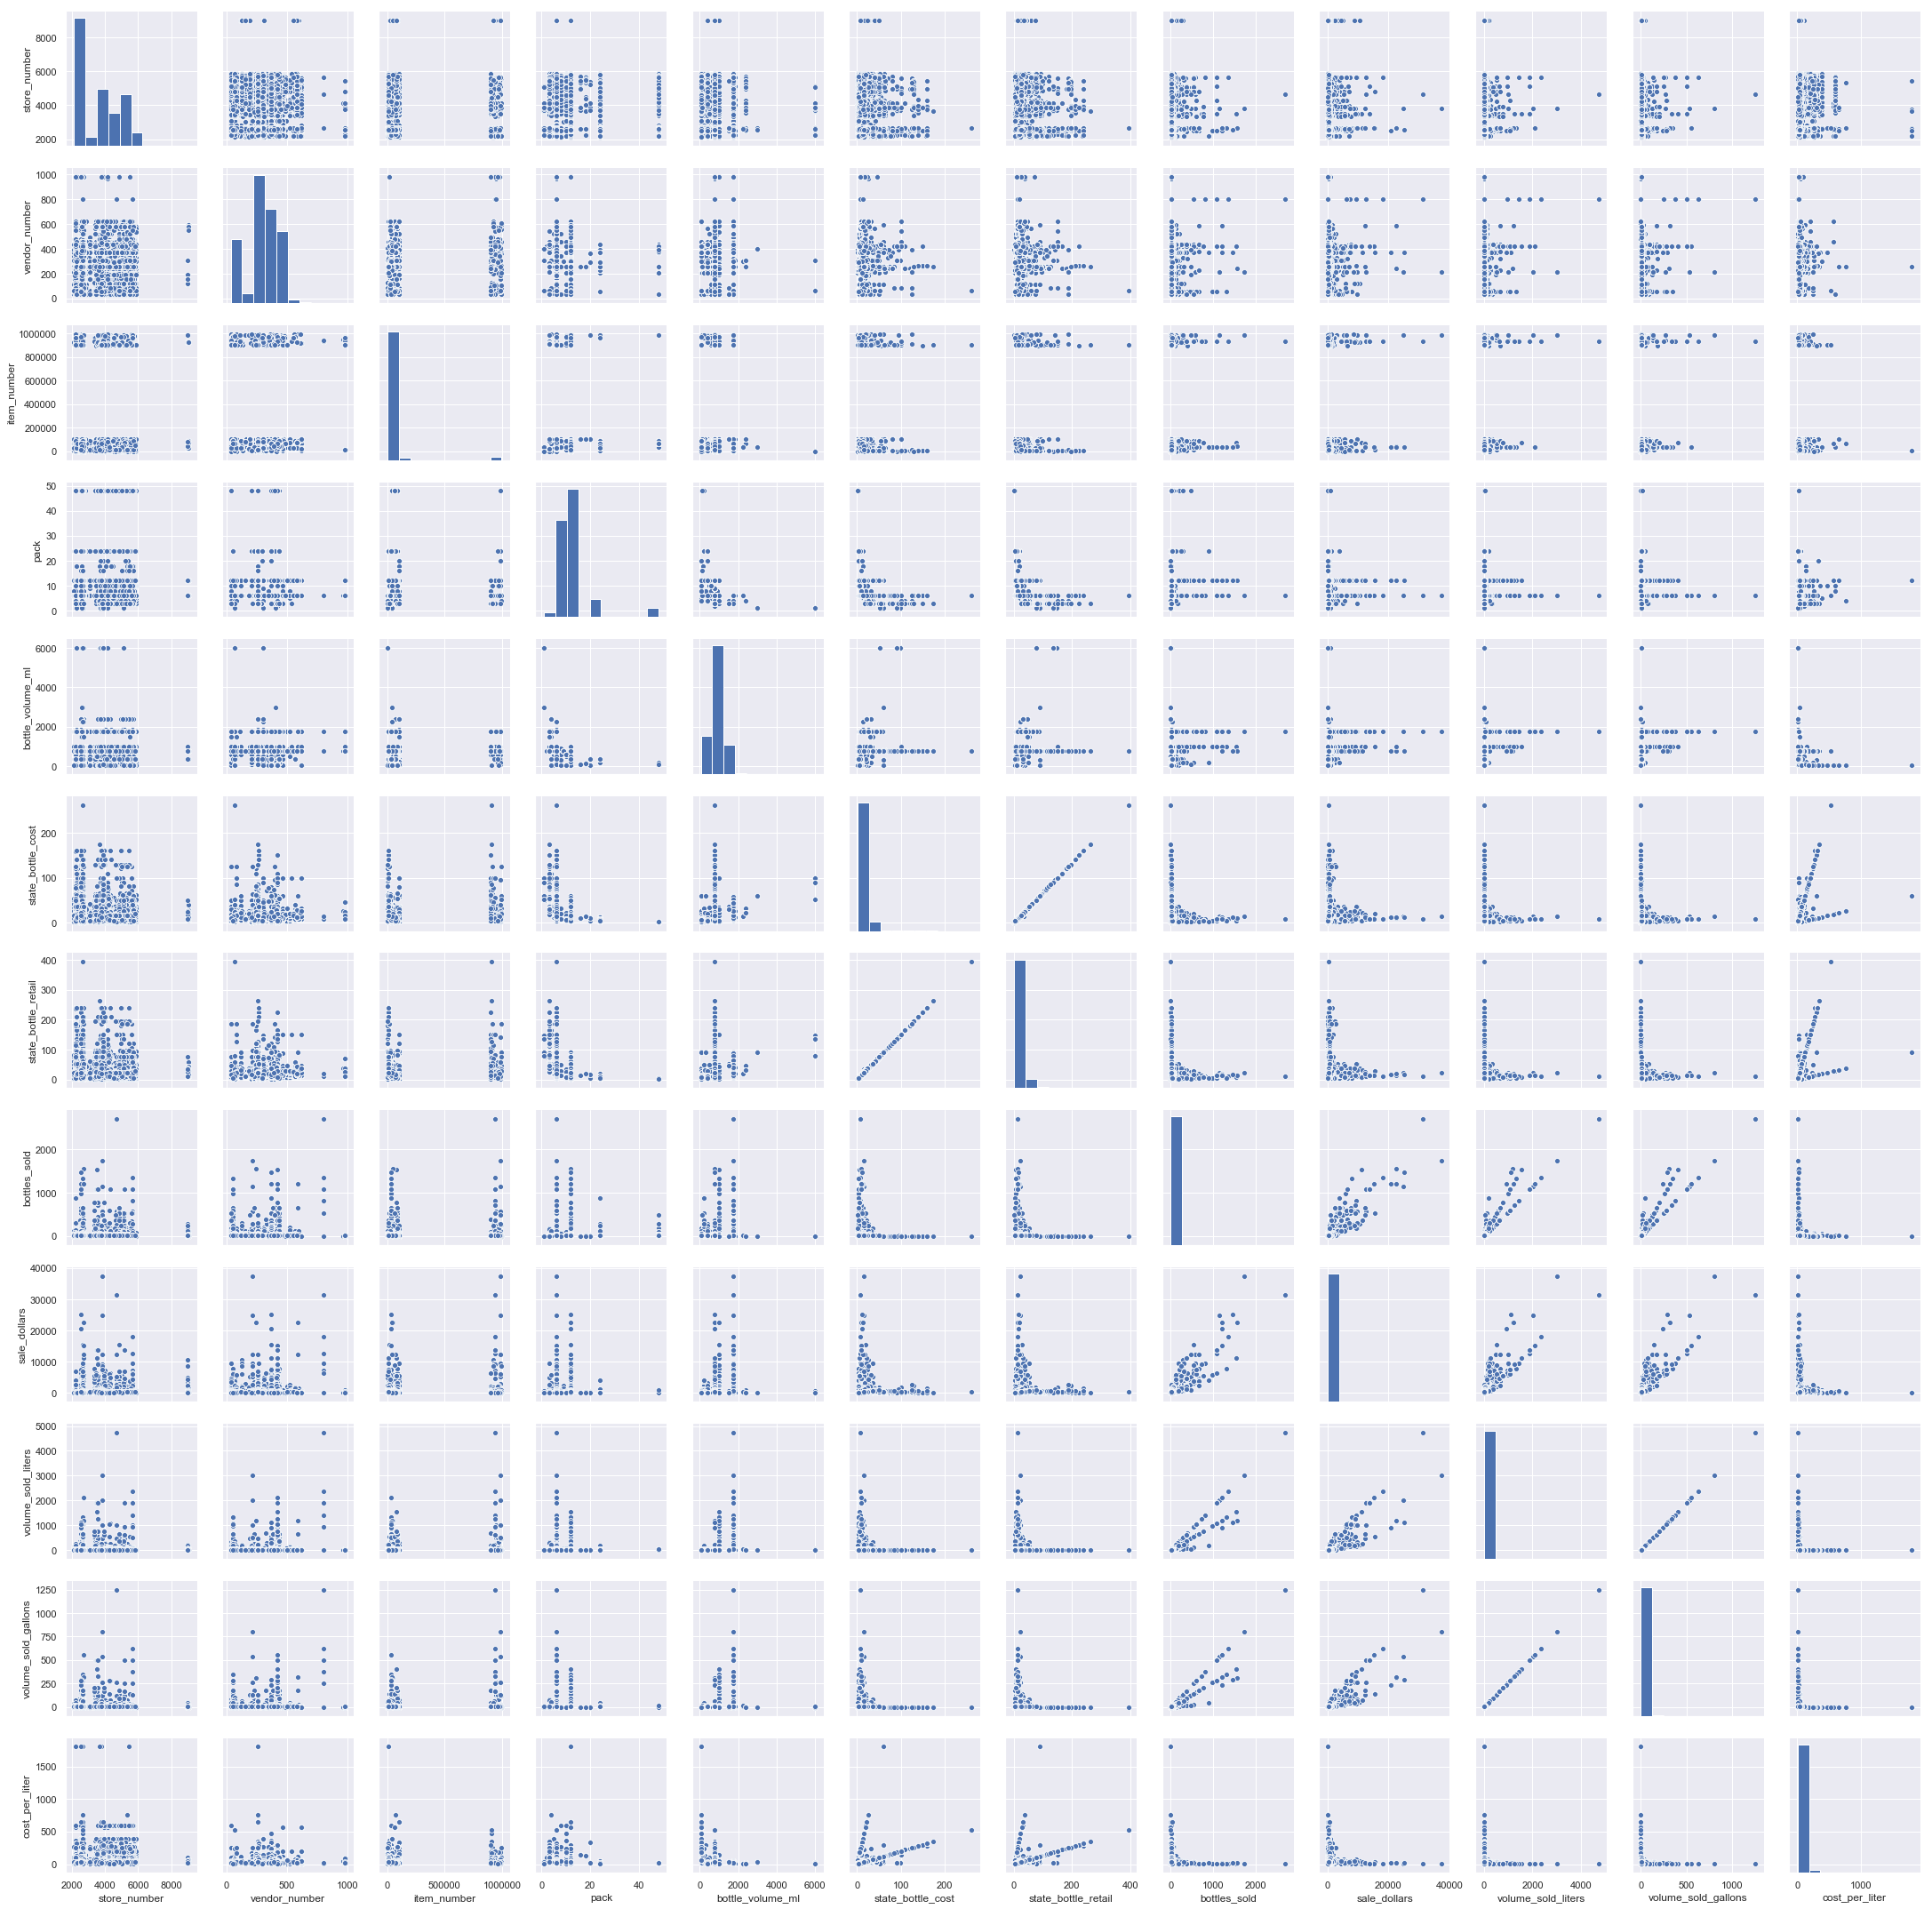

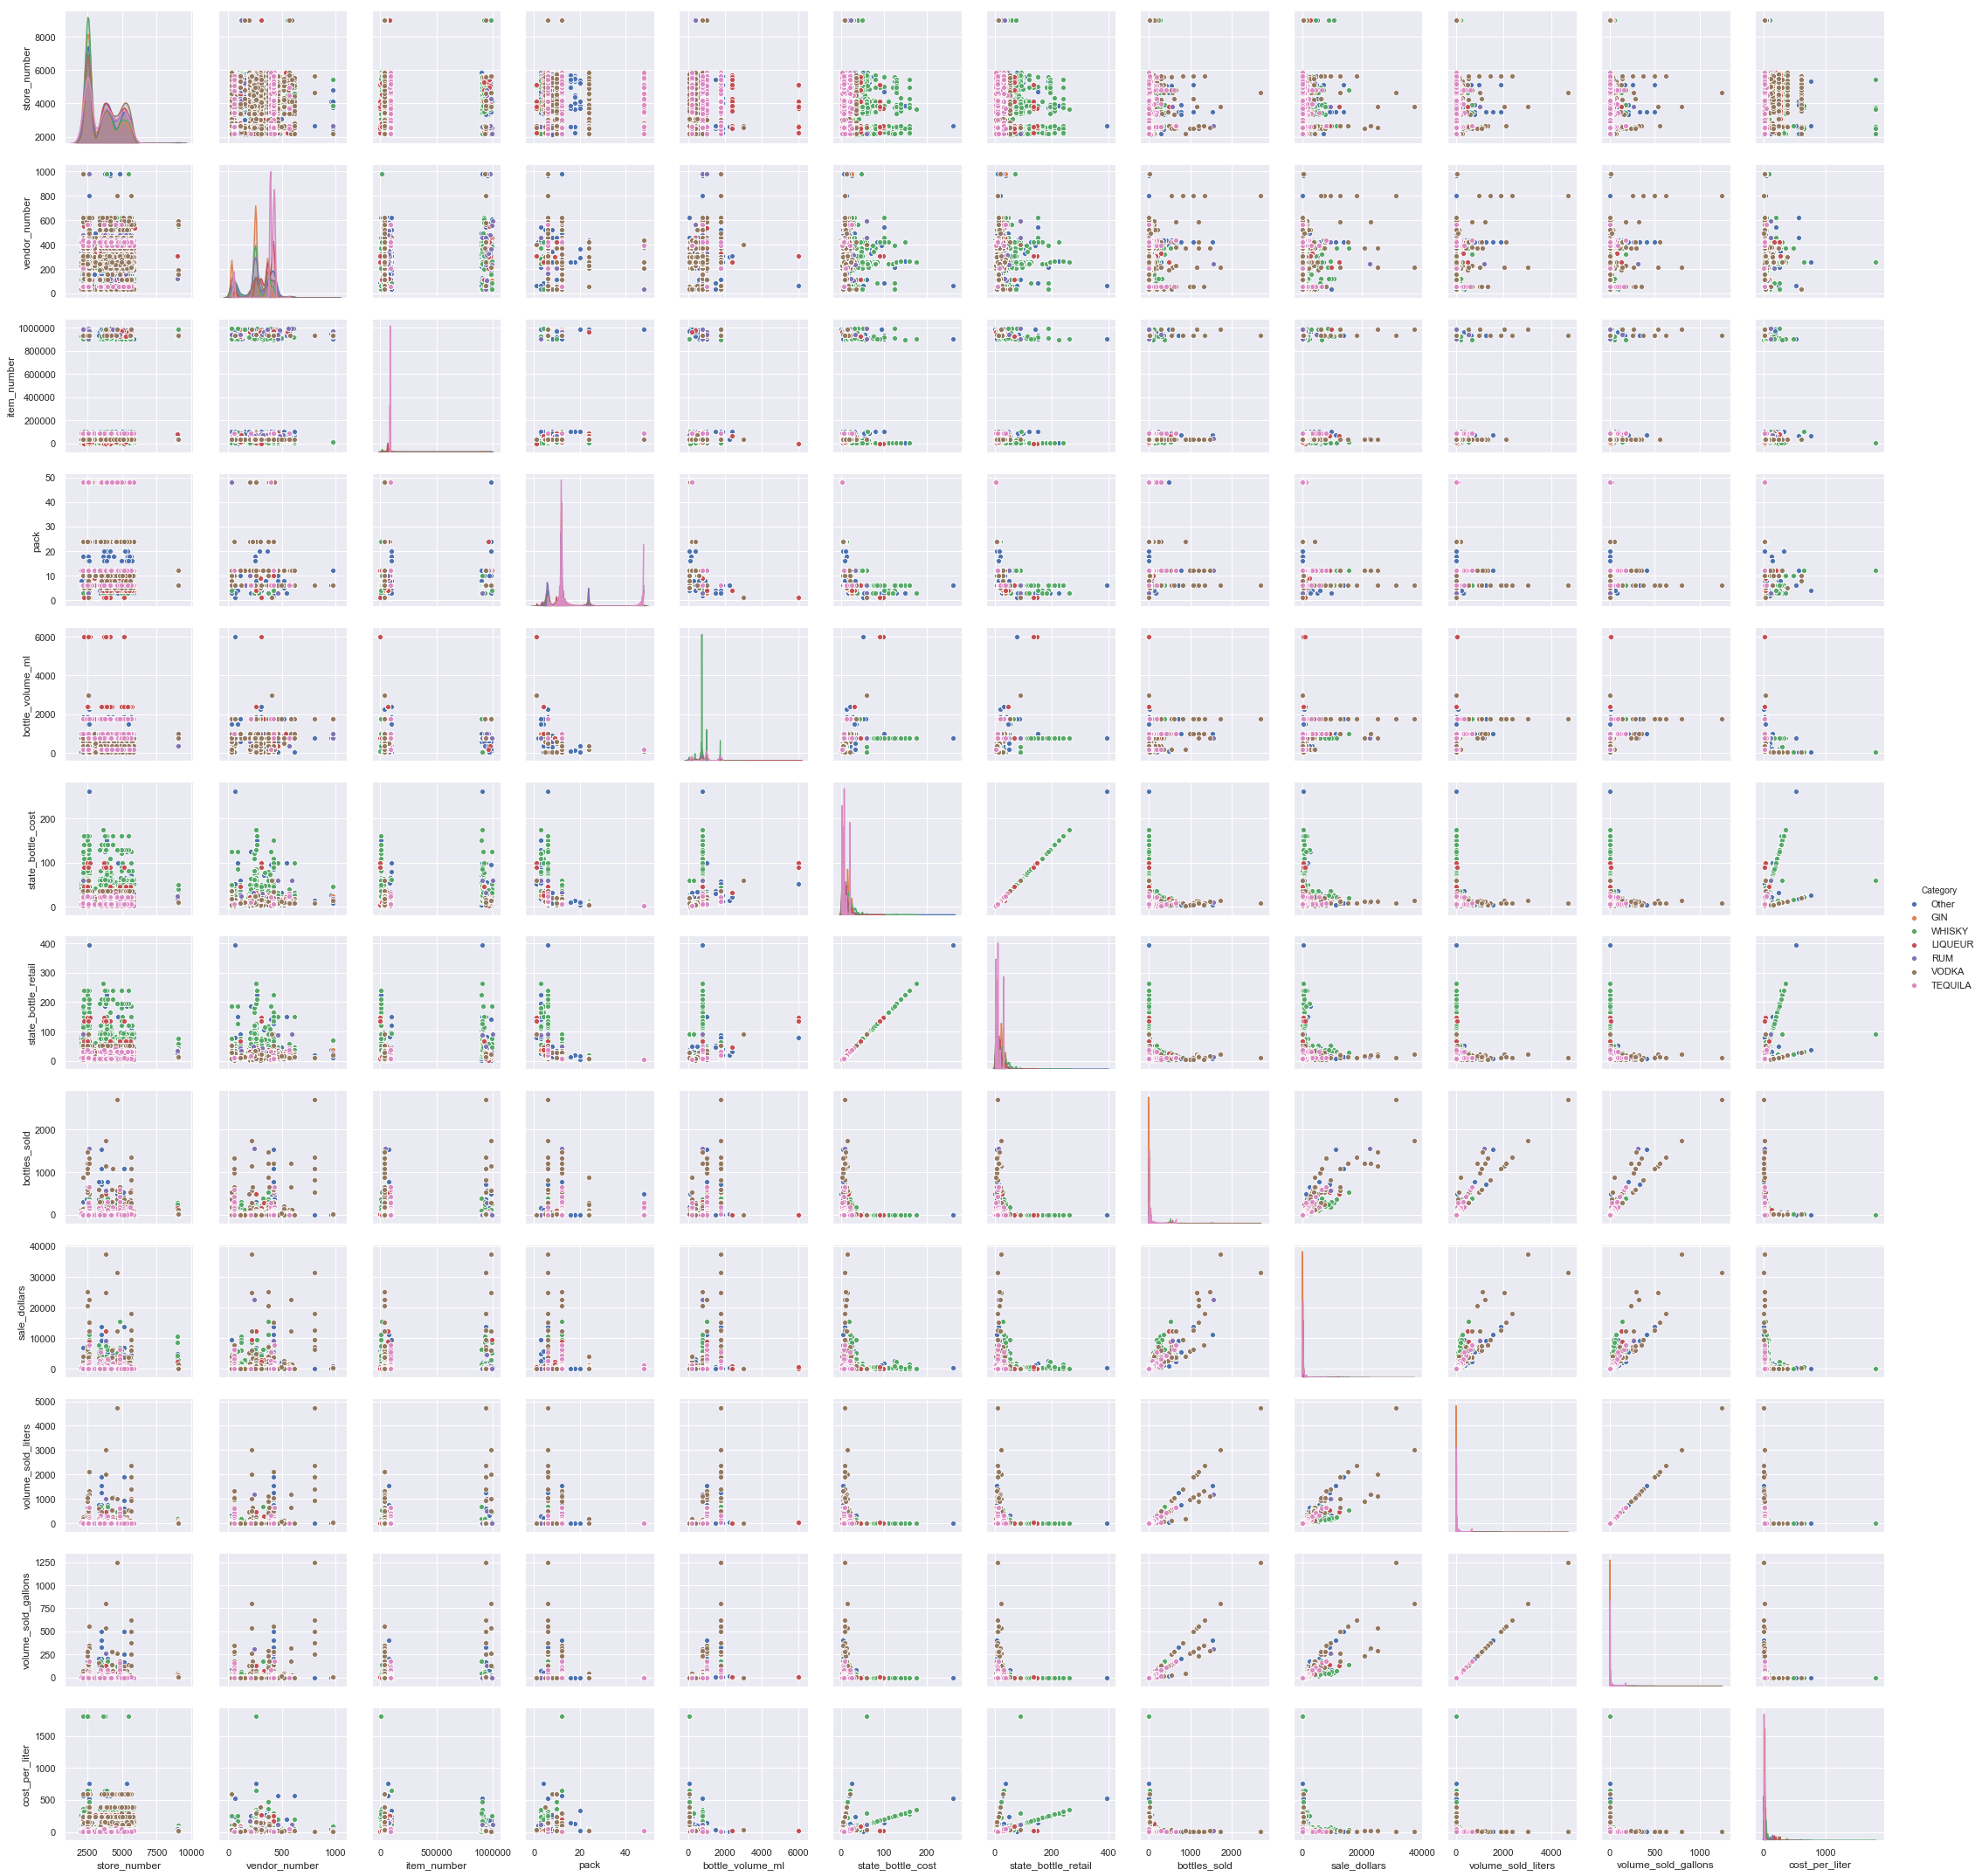

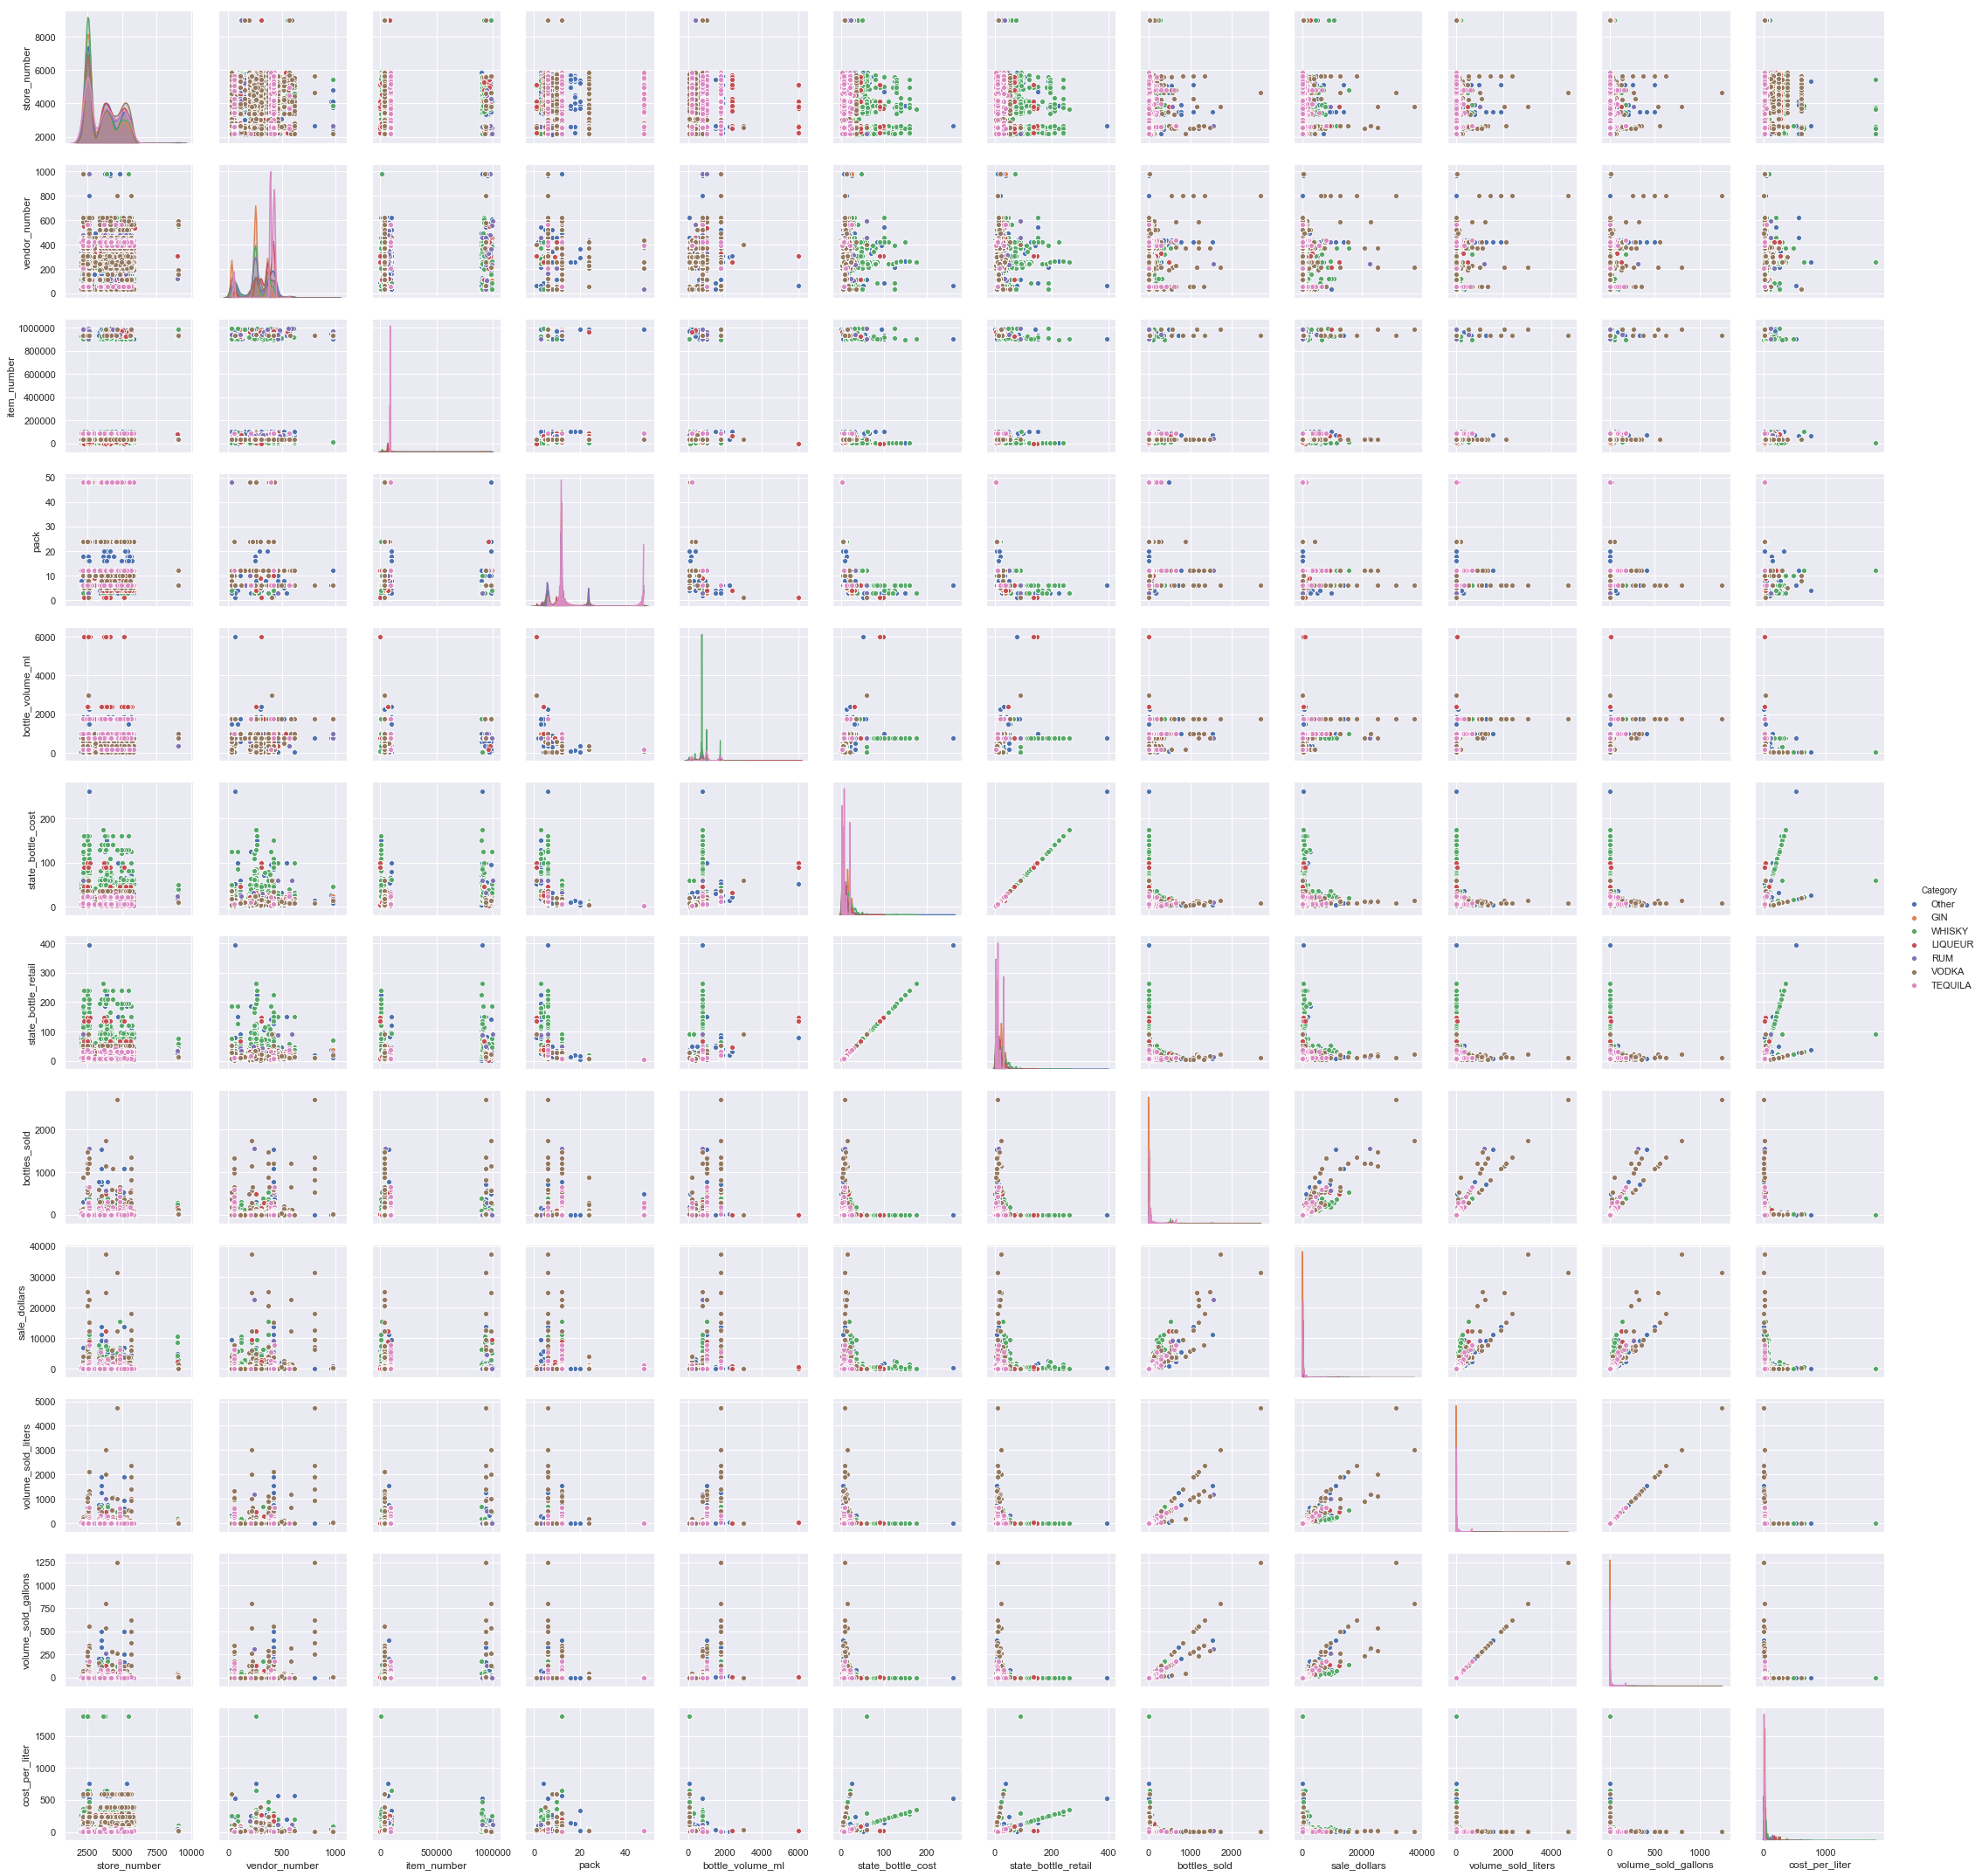

In [39]:
import seaborn as sns
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

# now try plotting some of the previous plots, way more visually appealing!!
#https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166
sns.pairplot(df)
sns.pairplot(df, hue= 'Category')
sns.pairplot(df, hue='Category', diag_kind = 'kde')

## Explore Attributes and Class
Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification).



## New Features 
Are there other features that could be added to the data or created from existing features? Which ones?



Day of the week
education
median population
income groups
age groups
employment
Grouping of Liquor Brands

## Exceptional Work 
You have free reign to provide additional analyses. One idea: implement dimensionality reduction, then visualize and interpret the results.